# Dynamic Tool Discovery: RAG vs No-RAG Evaluation

This notebook analyzes the results of dynamic tool discovery experiments on the **BFCL v4 Live Multiple** benchmark using **GPT-5-mini**.

**Experimental setup:**
- **Task:** Given a user query, select and invoke the correct tool(s) from a pool of candidate tools
- **Tool pool sizes (S):** 50, 75, 100 distractor tools (plus the correct tool(s))
- **Methods:** 
  - **No RAG** — all S tools passed directly to the LLM
  - **RAG** — embed query + tool descriptions, retrieve top-K=5 tools via cosine similarity, pass only those to the LLM
- **Eval samples:** 1,053 queries per configuration
- **Evaluator:** GPT-5-mini judges correctness of tool name + parameters

In [10]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'font.size': 12,
    'figure.dpi': 120,
})

In [11]:
RESULTS_DIR = 'results'

configs = [
    ('50-tools-gpt-5-norag-results.pkl',  50,  'No RAG'),
    ('50-tools-gpt-5-rag-results.pkl',    50,  'RAG'),
    ('75-tools-gpt-5-norag-results.pkl',  75,  'No RAG'),
    ('75-tools-gpt-5-rag-results.pkl',    75,  'RAG'),
    ('100-tools-gpt-5-norag-results.pkl', 100, 'No RAG'),
    ('100-tools-gpt-5-rag-results.pkl',   100, 'RAG'),
]

dfs = {}
for fname, n_tools, method in configs:
    with open(f'{RESULTS_DIR}/{fname}', 'rb') as f:
        df = pickle.load(f)
    # Normalize error reasons — treat timeout errors as missing tool calls
    df.loc[df['reason'].str.startswith('error:', na=False), 'reason'] = 'error (timeout)'
    df['correct'] = df['correct'].fillna(False)
    dfs[(n_tools, method)] = df

print(f'Loaded {len(dfs)} experiment configurations')
print(f'Samples per config: {len(df)}')

Loaded 6 experiment configurations
Samples per config: 1053


## 1. Summary Table

In [12]:
rows = []
for (n_tools, method), df in dfs.items():
    valid = df[df['latency'].notna()]
    rows.append({
        'Tool Pool Size (S)': n_tools,
        'Method': method,
        'Accuracy (%)': round(df['correct'].mean() * 100, 2),
        'Correct': int(df['correct'].sum()),
        'Total': len(df),
        'Latency Mean (s)': round(valid['latency'].mean(), 2),
        'Latency Median (s)': round(valid['latency'].median(), 2),
        'Latency p95 (s)': round(valid['latency'].quantile(0.95), 2),
    })

summary_df = pd.DataFrame(rows)
summary_df

,Tool Pool Size (S),Method,Accuracy (%),Correct,Total,Latency Mean (s),Latency Median (s),Latency p95 (s)
0,50,No RAG,63.44,668,1053,14.91,5.63,12.59
1,50,RAG,61.25,645,1053,35.07,4.18,18.55
2,75,No RAG,61.44,647,1053,8.51,5.10,10.40
3,75,RAG,60.97,642,1053,34.44,4.42,16.61
4,100,No RAG,60.02,632,1053,14.44,6.47,13.70
5,100,RAG,59.83,630,1053,31.08,4.75,15.33


## 2. Accuracy: RAG vs No-RAG across Tool Pool Sizes

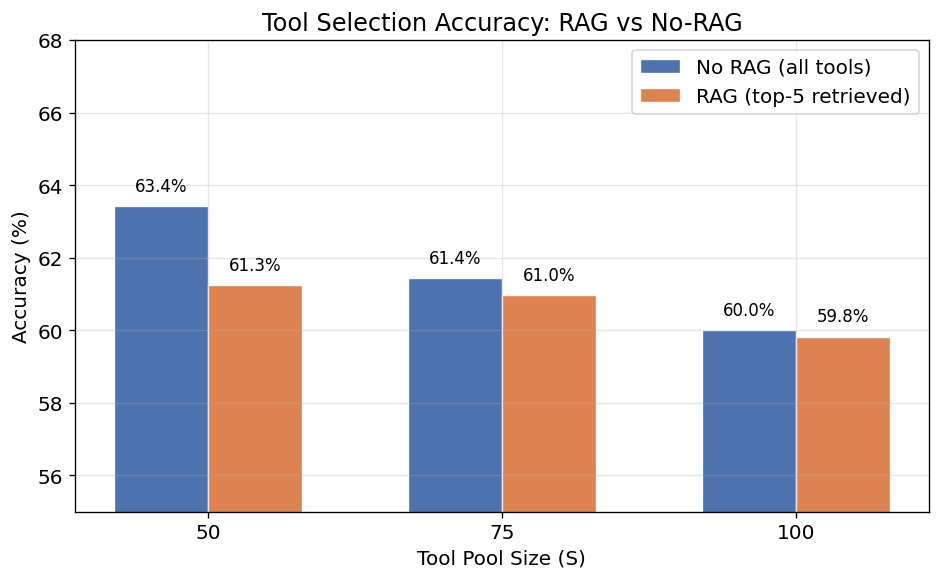

In [13]:
tool_sizes = [50, 75, 100]
acc_norag = [dfs[(s, 'No RAG')]['correct'].mean() * 100 for s in tool_sizes]
acc_rag   = [dfs[(s, 'RAG')]['correct'].mean() * 100 for s in tool_sizes]

fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(tool_sizes))
width = 0.32

bars1 = ax.bar(x - width/2, acc_norag, width, label='No RAG (all tools)', color='#4C72B0', edgecolor='white', linewidth=0.8)
bars2 = ax.bar(x + width/2, acc_rag,   width, label='RAG (top-5 retrieved)', color='#DD8452', edgecolor='white', linewidth=0.8)

for bars in [bars1, bars2]:
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.3, f'{h:.1f}%', ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Tool Pool Size (S)')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Tool Selection Accuracy: RAG vs No-RAG')
ax.set_xticks(x)
ax.set_xticklabels(tool_sizes)
ax.set_ylim(55, 68)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

## 3. Error Breakdown by Failure Reason

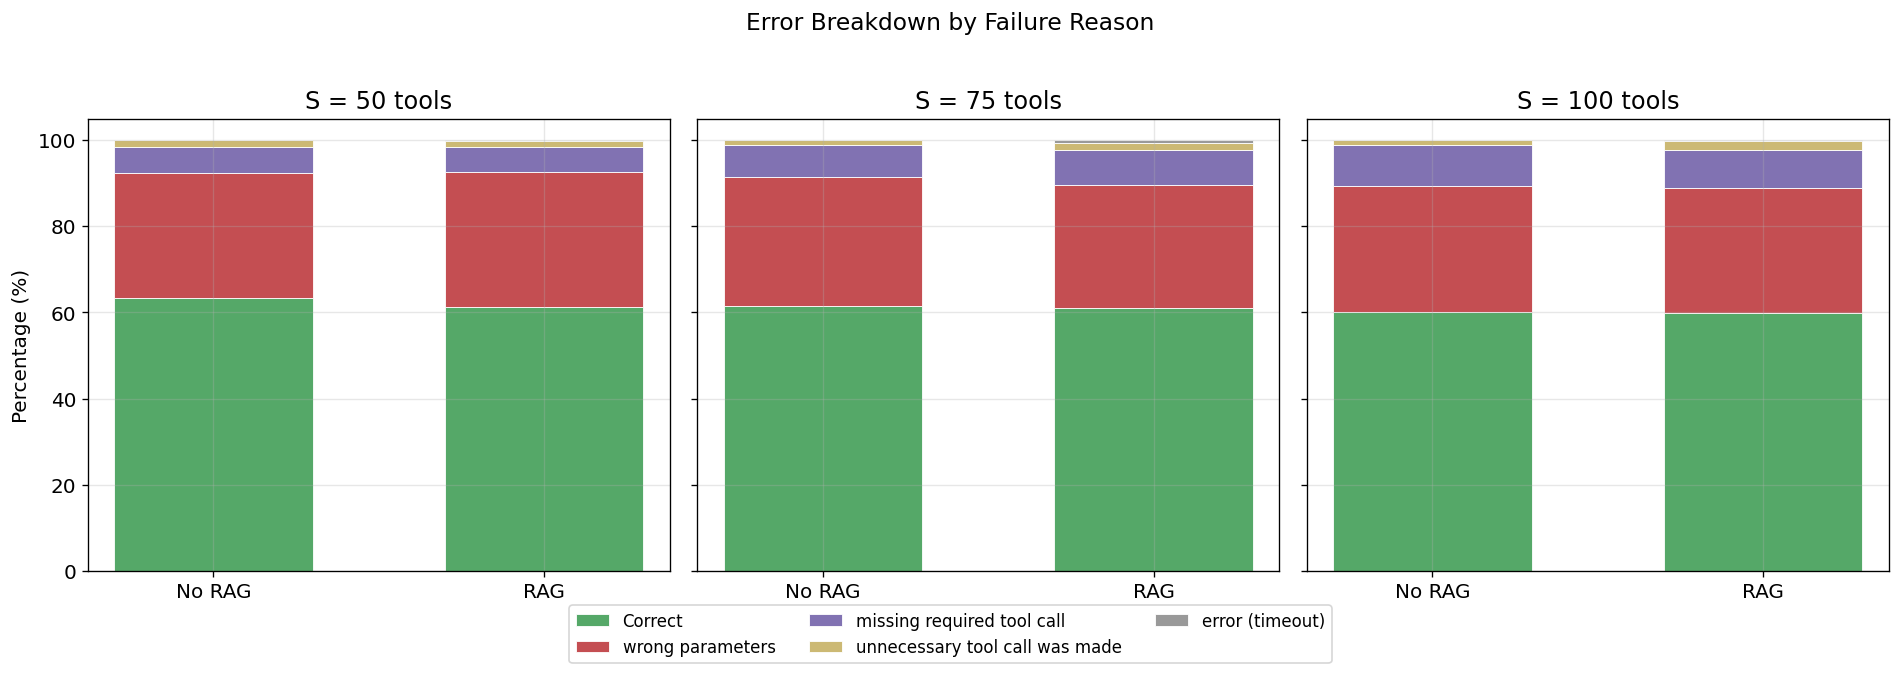

In [14]:
reason_order = ['Correct', 'wrong parameters', 'missing required tool call', 'unnecessary tool call was made', 'error (timeout)']
colors = ['#55a868', '#c44e52', '#8172b2', '#ccb974', '#999999']

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

for idx, s in enumerate(tool_sizes):
    ax = axes[idx]
    for method_idx, method in enumerate(['No RAG', 'RAG']):
        df = dfs[(s, method)]
        counts = df['reason'].value_counts()
        fracs = [(counts.get(r, 0) / len(df)) * 100 for r in reason_order]
        
        bottom = 0
        for i, (frac, reason) in enumerate(zip(fracs, reason_order)):
            label = reason if (idx == 0 and method_idx == 0) else None
            ax.bar(method_idx, frac, bottom=bottom, color=colors[i], label=label, edgecolor='white', linewidth=0.5, width=0.6)
            bottom += frac
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['No RAG', 'RAG'])
    ax.set_title(f'S = {s} tools')
    ax.set_ylim(0, 105)

axes[0].set_ylabel('Percentage (%)')
fig.suptitle('Error Breakdown by Failure Reason', fontsize=14, y=1.02)
fig.legend(reason_order, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.08), fontsize=10)
plt.tight_layout()
plt.show()

## 4. Latency Comparison

/var/folders/0k/6q45p4911wg51b_wnhdf6v1m0000gn/T/ipykernel_50226/4038805805.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True, widths=0.5,


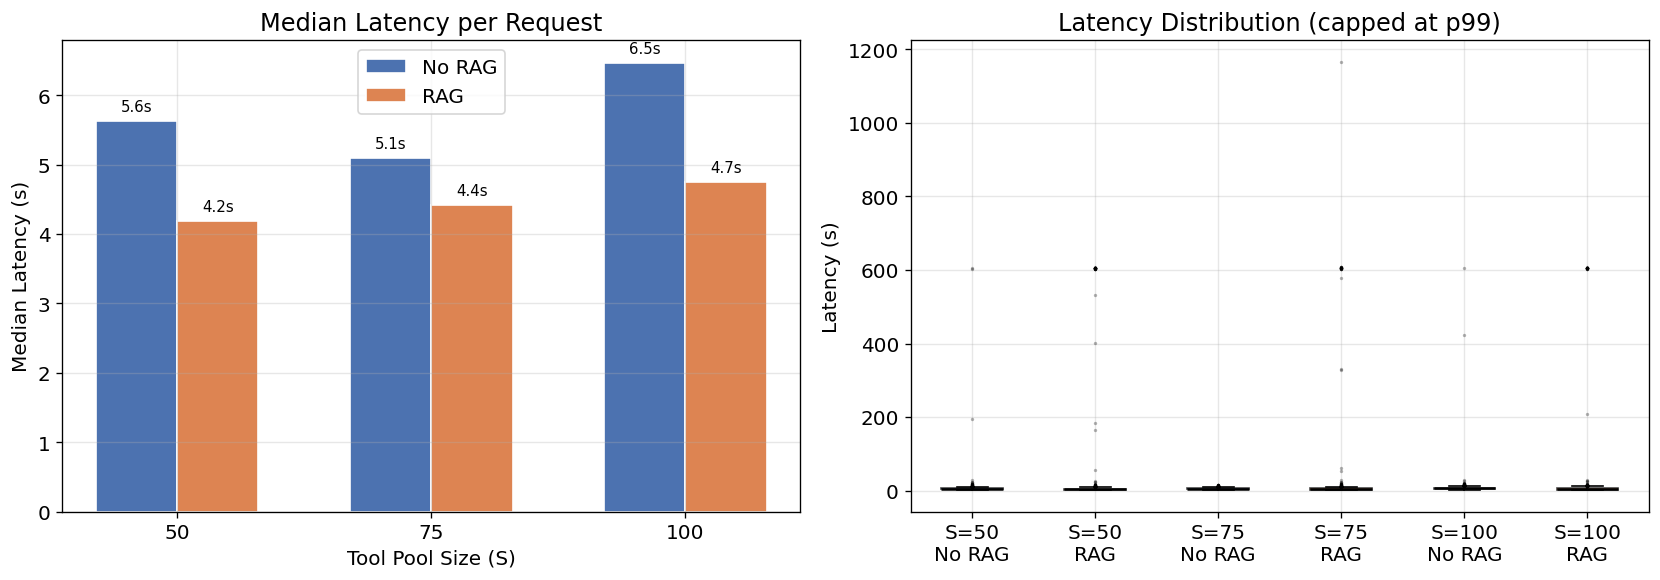

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# --- Median latency bar chart ---
median_norag = [dfs[(s, 'No RAG')]['latency'].median() for s in tool_sizes]
median_rag   = [dfs[(s, 'RAG')]['latency'].dropna().median() for s in tool_sizes]

x = np.arange(len(tool_sizes))
width = 0.32
bars1 = ax1.bar(x - width/2, median_norag, width, label='No RAG', color='#4C72B0', edgecolor='white')
bars2 = ax1.bar(x + width/2, median_rag,   width, label='RAG',    color='#DD8452', edgecolor='white')

for bars in [bars1, bars2]:
    for bar in bars:
        h = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, h + 0.1, f'{h:.1f}s', ha='center', va='bottom', fontsize=9)

ax1.set_xlabel('Tool Pool Size (S)')
ax1.set_ylabel('Median Latency (s)')
ax1.set_title('Median Latency per Request')
ax1.set_xticks(x)
ax1.set_xticklabels(tool_sizes)
ax1.legend()

# --- Box plot ---
box_data = []
box_labels = []
box_colors = []
for s in tool_sizes:
    for method, color in [('No RAG', '#4C72B0'), ('RAG', '#DD8452')]:
        latencies = dfs[(s, method)]['latency'].dropna()
        # Cap at p99 for readability
        cap = latencies.quantile(0.99)
        box_data.append(latencies[latencies <= cap])
        box_labels.append(f'S={s}\n{method}')
        box_colors.append(color)

bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True, widths=0.5,
                 medianprops=dict(color='black', linewidth=1.5),
                 flierprops=dict(marker='.', markersize=2, alpha=0.3))

for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_ylabel('Latency (s)')
ax2.set_title('Latency Distribution (capped at p99)')

plt.tight_layout()
plt.show()

## 5. Accuracy Degradation Trend

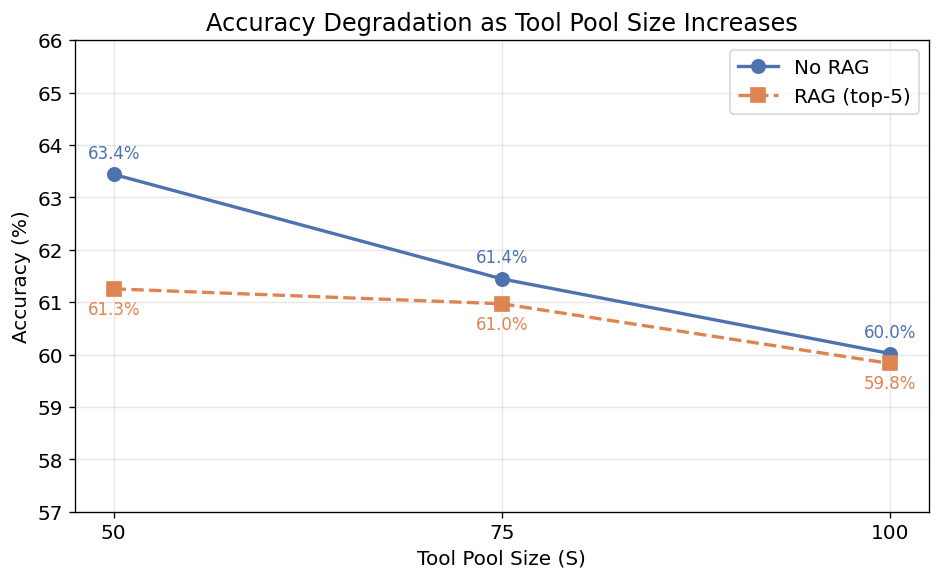

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(tool_sizes, acc_norag, 'o-', color='#4C72B0', linewidth=2, markersize=8, label='No RAG')
ax.plot(tool_sizes, acc_rag,   's--', color='#DD8452', linewidth=2, markersize=8, label='RAG (top-5)')

for i, s in enumerate(tool_sizes):
    ax.annotate(f'{acc_norag[i]:.1f}%', (s, acc_norag[i]), textcoords='offset points', xytext=(0, 10), ha='center', fontsize=10, color='#4C72B0')
    ax.annotate(f'{acc_rag[i]:.1f}%',   (s, acc_rag[i]),   textcoords='offset points', xytext=(0, -15), ha='center', fontsize=10, color='#DD8452')

ax.set_xlabel('Tool Pool Size (S)')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy Degradation as Tool Pool Size Increases')
ax.set_xticks(tool_sizes)
ax.set_ylim(57, 66)
ax.legend()
plt.tight_layout()
plt.show()

## 6. Failure Mode Counts (Detailed)

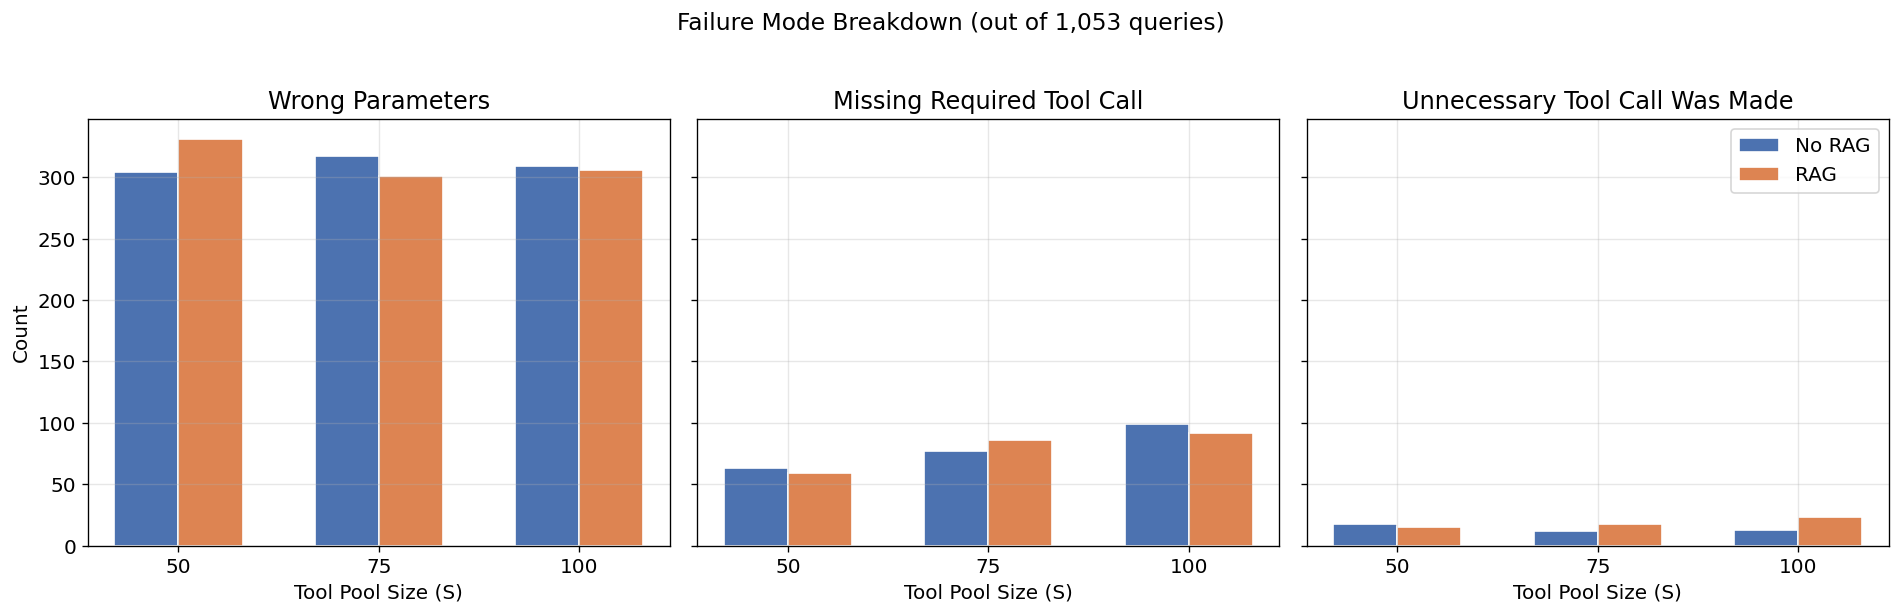

In [17]:
failure_reasons = ['wrong parameters', 'missing required tool call', 'unnecessary tool call was made']

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

for i, reason in enumerate(failure_reasons):
    ax = axes[i]
    norag_counts = [dfs[(s, 'No RAG')]['reason'].eq(reason).sum() for s in tool_sizes]
    rag_counts   = [dfs[(s, 'RAG')]['reason'].eq(reason).sum() for s in tool_sizes]
    
    x = np.arange(len(tool_sizes))
    ax.bar(x - width/2, norag_counts, width, label='No RAG', color='#4C72B0', edgecolor='white')
    ax.bar(x + width/2, rag_counts,   width, label='RAG',    color='#DD8452', edgecolor='white')
    
    ax.set_xlabel('Tool Pool Size (S)')
    ax.set_xticks(x)
    ax.set_xticklabels(tool_sizes)
    ax.set_title(reason.title())
    if i == 0:
        ax.set_ylabel('Count')
    if i == 2:
        ax.legend()

fig.suptitle('Failure Mode Breakdown (out of 1,053 queries)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 7. RAG vs No-RAG Per-Sample Agreement

/var/folders/0k/6q45p4911wg51b_wnhdf6v1m0000gn/T/ipykernel_50226/1441553282.py:9: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  only_norag   = (norag & ~rag).sum()
/var/folders/0k/6q45p4911wg51b_wnhdf6v1m0000gn/T/ipykernel_50226/1441553282.py:11: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  both_wrong   = (~norag & ~rag).sum()


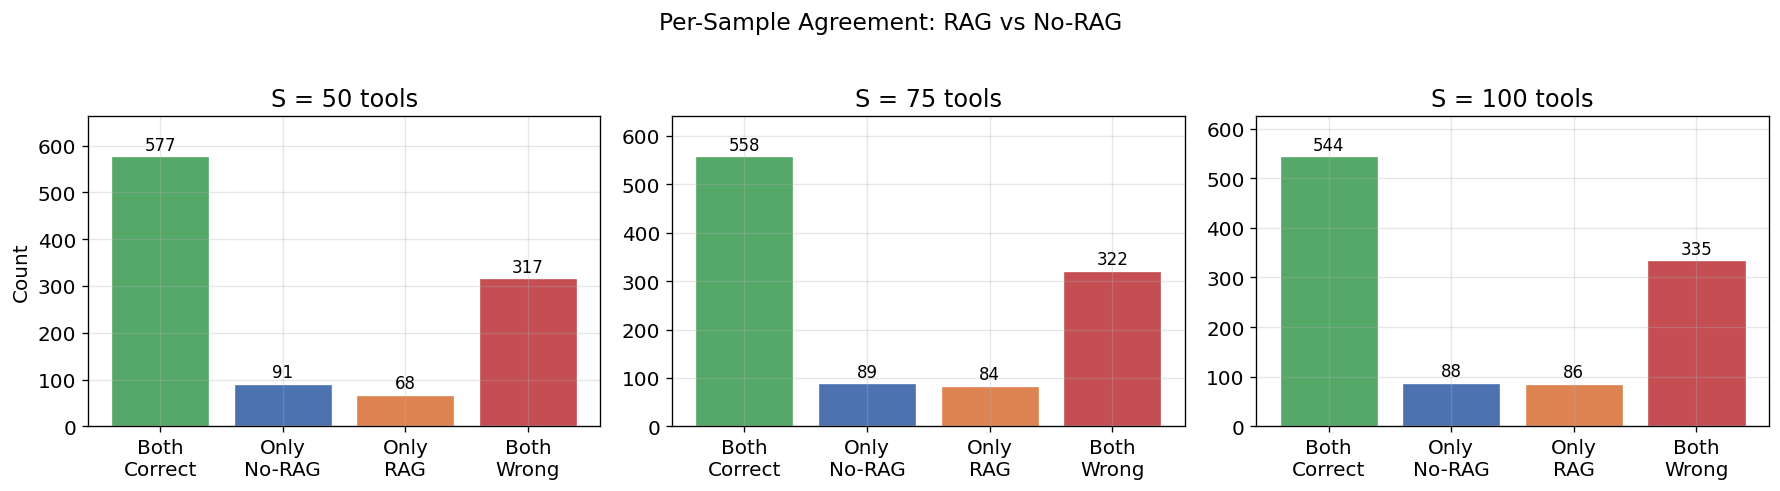

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, s in enumerate(tool_sizes):
    ax = axes[idx]
    norag = dfs[(s, 'No RAG')]['correct'].values
    rag   = dfs[(s, 'RAG')]['correct'].values
    
    both_correct = (norag & rag).sum()
    only_norag   = (norag & ~rag).sum()
    only_rag     = (~norag & rag).sum()
    both_wrong   = (~norag & ~rag).sum()
    
    labels = ['Both\nCorrect', 'Only\nNo-RAG', 'Only\nRAG', 'Both\nWrong']
    values = [both_correct, only_norag, only_rag, both_wrong]
    bar_colors = ['#55a868', '#4C72B0', '#DD8452', '#c44e52']
    
    bars = ax.bar(labels, values, color=bar_colors, edgecolor='white', linewidth=0.8)
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, str(val), ha='center', va='bottom', fontsize=10)
    
    ax.set_title(f'S = {s} tools')
    ax.set_ylim(0, max(values) * 1.15)
    if idx == 0:
        ax.set_ylabel('Count')

fig.suptitle('Per-Sample Agreement: RAG vs No-RAG', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 8. Key Takeaways

| Finding | Detail |
|---------|--------|
| **No-RAG slightly outperforms RAG** | Across all tool pool sizes, passing all tools to the LLM yields ~0.5-2% higher accuracy than RAG filtering to top-5 |
| **Accuracy degrades with pool size** | Accuracy drops ~3.4pp from S=50 to S=100 for No-RAG, suggesting tool disambiguation becomes harder with more candidates |
| **Wrong parameters dominate errors** | ~29-30% of all queries produce wrong parameter values — the model selects the right tool but fills arguments incorrectly |
| **RAG has higher median latency variability** | RAG adds embedding + retrieval overhead, though median per-call latency is sometimes lower because fewer tools are sent to the LLM |
| **Missing tool calls increase with pool size** | Goes from ~6% at S=50 to ~9.4% at S=100 (No-RAG), indicating the LLM struggles more to find the right tool in larger pools |